In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import matplotlib.colors
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
# now we look at the same thing for clique expanded

filepath = "filtered_data/adjacent1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)


label1 = 'bin1'
label2 = 'bin2'

hoSplitExp = {}
indShape = None

for cell in df['cell'].unique():
    
    cellDf = df[(df['cell'] == cell)].reset_index(drop=True)
    cellBinned = binning.wholeGenomeBinData(cellDf, bins, label1, label2)
    A = pcu.getHic(cellBinned, bins, label1, label2)
    
    print(f"{cell=}")
    indShape = len(A)
    
    hoSplitExp[cell] = A
    
print('done binning.')


newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredPoreCIndex = list(range(0, indShape))

print('done chrom info')


chromosome = ['chr2']

chrom2Exp = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = pcu.Abin(A)
    np.fill_diagonal(A, 1)
    return A
    

for runId in hoSplitExp.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    A = processMat(hoSplitExp[runId], ind)
    
    chrom2Exp[runId] = A
    
print('done')

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(286943, 66)
cell='run01'
cell='run02'
cell='run04'
cell='run05'
cell='run06'
cell='run07'
done binning.
done chrom info
done


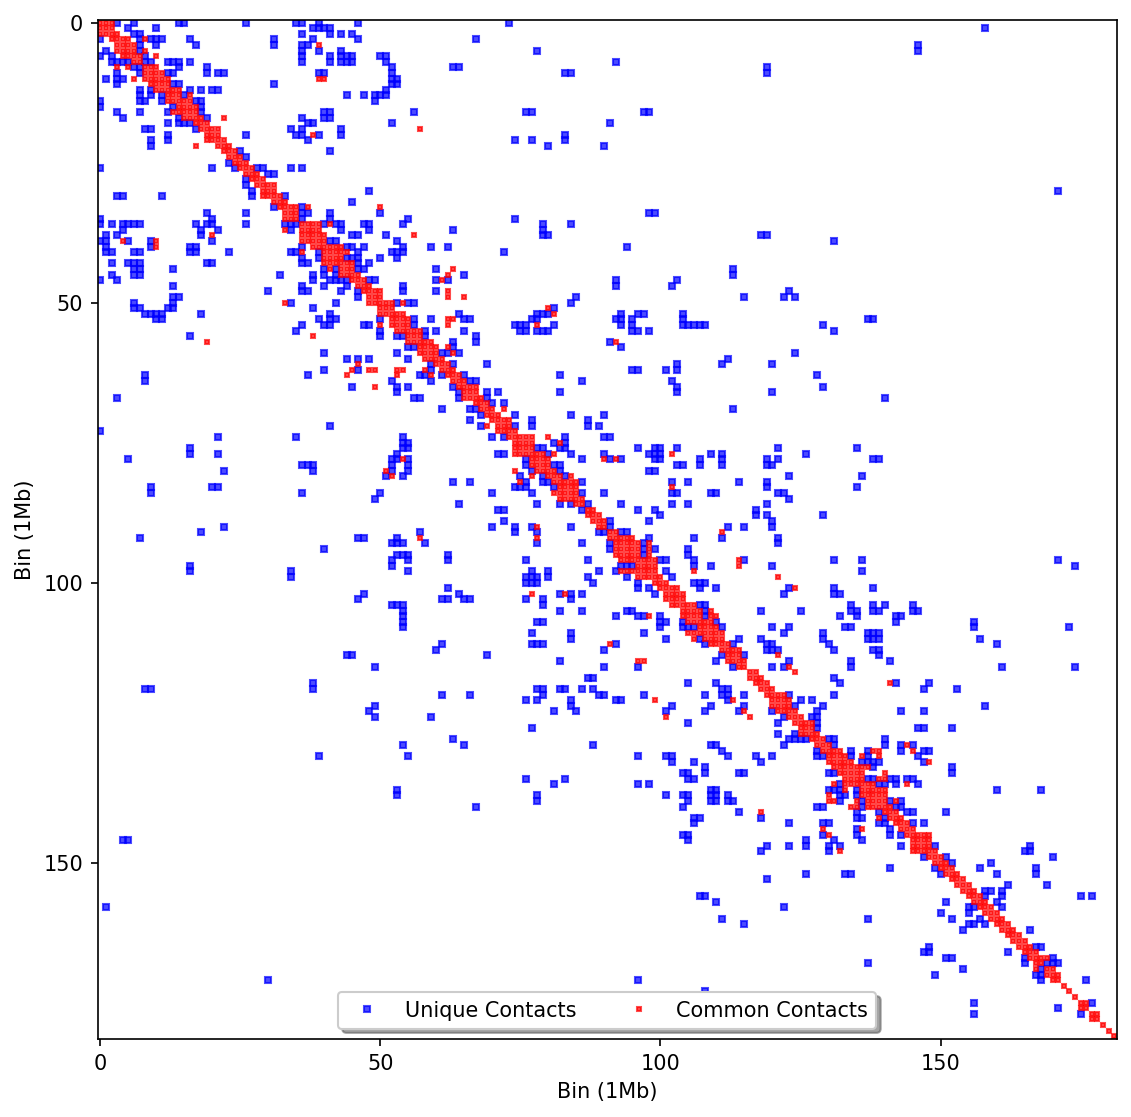

In [4]:
ensmble = np.zeros((182, 182))

for runId, A in chrom2Exp.items():
    
    ensmble += A
    
uniqueContacts = np.where(ensmble == 1, 1, 0)
commonContacts = np.where(ensmble > 1, 1, 0)


plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 9, 9

plt.spy(uniqueContacts, c='blue', alpha=0.7, marker='s', markersize=3, label='Unique Contacts')
plt.spy(commonContacts, c='red', alpha=0.7, marker='s', markersize=2, label='Common Contacts')

plt.xlabel('Bin (1Mb)')
plt.ylabel('Bin (1Mb)')

ax = plt.gca()
ax.xaxis.tick_bottom()

ax.set_aspect('equal')

plt.legend(loc='lower center',fancybox=True, shadow=True, ncol=5)